# Gradient Boosting Regression vs. Quantile Regression 

Advanced machine learning algorithms are taking over traditional methods a lot lately.  
But how close traditional model prediction can get to advance ML prediction?  

This notebook gives a chance to compare predictions of Gradient Boosting regression vs. traditional regression.
To keep this comparison adequate we will build:
1. Quantile Regression (median)
2. Gradient boosted regression with least absolute deviation loss function (quantile=0.5)

So in both cases we are predicting median house price, hense the loss functions used in both approaches is the same (LAD).

#### Data and the Challenge
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this Kaggle competition challenges you to predict the final price of each home. More details about the competition & data can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)



#### Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.graphics.gofplots import qqplot
plt.style.use('bmh')
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import statsmodels.formula.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#### Read in Training Data

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
df_test = pd.read_csv('test.csv')
set(df_train.columns).difference(df_test.columns)

{'SalePrice'}

In [5]:
df_train['IsTrain'] = 1
df_test['IsTrain']=0
df = pd.concat((df_train, df_test), sort=False).reset_index(drop=True)

In [6]:
df.groupby('IsTrain')['IsTrain'].count()

IsTrain
0    1459
1    1460
Name: IsTrain, dtype: int64

*Will leave the testing sample out of analysis for now (we're not submitting anything here)*

## Exploratory Data Analysis

Let's drop ID into a separate dataframe for later

In [7]:
df_IDs = df[['Id','IsTrain']]
del df['Id']

#### Identifying categorical features by number of unique values

In [8]:
VarCatCnt = df[:].nunique()
df_uniq = pd.DataFrame({'VarName': VarCatCnt.index,'cnt': VarCatCnt.values})
df_uniq.head()

VarName   cnt
0   MSSubClass    16
1     MSZoning     5
2  LotFrontage   128
3      LotArea  1951
4       Street     2

Create a subset of continuous numeric features (i.e. that have more than 30 categories)

In [9]:
df_contVars = df_uniq[(df_uniq.cnt > 30) | (df_uniq.VarName == 'SalePrice') | (df_uniq.VarName == 'IsTrain')]
df_num = df[df_contVars.VarName]
df_num.shape

(2919, 23)

Create a subset of categorical features (i.e. with less than 30 categories)

In [10]:
df_categVars = df_uniq[(df_uniq.cnt <= 30) | (df_uniq.VarName == 'SalePrice') | (df_uniq.VarName == 'IsTrain')]
df_categ = df[df_categVars.VarName]
df_categ.shape

(2919, 60)

### Imputing Missing Values

Will impute 0 for missings in **numeric** features, since there should be no confusion around the meaning of it

In [11]:
for i in range(0, len(df_num.columns)-1):
    if (df_num[df_num.columns[i]].isnull().sum() != 0) & (df_num.columns[i] != 'SalePrice'):
        print(df_num.columns[i] + " Null Count:" + str(df_num[df_num.columns[i]].isnull().sum()))
        df_num[df_num.columns[i]] = df_num[df_num.columns[i]].fillna(0)

LotFrontage Null Count:486
MasVnrArea Null Count:23
BsmtFinSF1 Null Count:1
BsmtFinSF2 Null Count:1
BsmtUnfSF Null Count:1
TotalBsmtSF Null Count:1
GarageYrBlt Null Count:159
GarageArea Null Count:1


Will impute 'NA' for missing values in **categoric** features (object type)

In [12]:
for i in range(0, len(df_categ.columns)-1):
    if (df_categ[df_categ.columns[i]].dtype == object) & (df_categ[df_categ.columns[i]].isnull().sum() != 0):
            print(df_categ.columns[i] + " Null Count:" + str(df_categ[df_categ.columns[i]].isnull().sum()))
            df_categ[df_categ.columns[i]].replace(np.nan, 'NA', inplace= True)

MSZoning Null Count:4
Alley Null Count:2721
Utilities Null Count:2
Exterior1st Null Count:1
Exterior2nd Null Count:1
MasVnrType Null Count:24
BsmtQual Null Count:81
BsmtCond Null Count:82
BsmtExposure Null Count:82
BsmtFinType1 Null Count:79
BsmtFinType2 Null Count:80
Electrical Null Count:1
KitchenQual Null Count:1
Functional Null Count:2
FireplaceQu Null Count:1420
GarageType Null Count:157
GarageFinish Null Count:159
GarageQual Null Count:159
GarageCond Null Count:159
PoolQC Null Count:2909
Fence Null Count:2348
MiscFeature Null Count:2814
SaleType Null Count:1


Checking if there are missing values in features with numeric-categories

In [13]:
df_categ_N = df_categ.select_dtypes(include = ['float64', 'int64'])
df_categ_N.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 17 columns):
MSSubClass      2919 non-null int64
OverallQual     2919 non-null int64
OverallCond     2919 non-null int64
BsmtFullBath    2917 non-null float64
BsmtHalfBath    2917 non-null float64
FullBath        2919 non-null int64
HalfBath        2919 non-null int64
BedroomAbvGr    2919 non-null int64
KitchenAbvGr    2919 non-null int64
TotRmsAbvGrd    2919 non-null int64
Fireplaces      2919 non-null int64
GarageCars      2918 non-null float64
PoolArea        2919 non-null int64
MoSold          2919 non-null int64
YrSold          2919 non-null int64
SalePrice       1460 non-null float64
IsTrain         2919 non-null int64
dtypes: float64(4), int64(13)
memory usage: 387.8 KB


In [14]:
df_categ['BsmtFullBath'].replace(np.nan, 0, inplace= True)
df_categ['BsmtHalfBath'].replace(np.nan, 0, inplace= True)

### Categoric Feature Analysis

Boxplot gives a good idea about how SalePrice is distributed across the categories.  
Distribution charts show how well each category is populated.

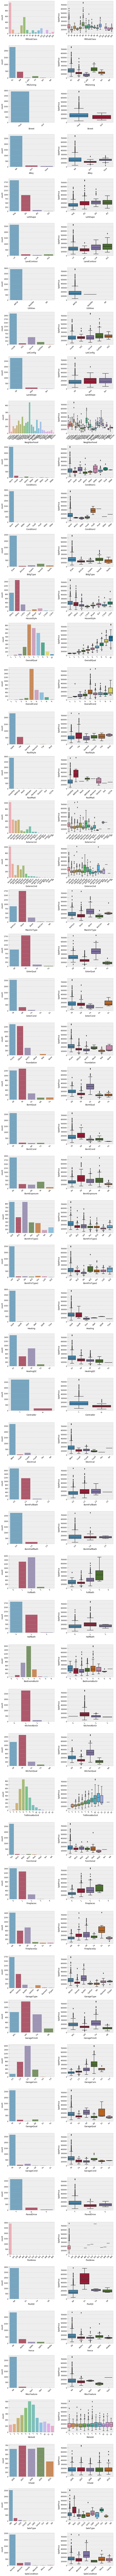

In [15]:
c = 0
fig, axes = plt.subplots(round((len(df_categ.columns)-2)), 2, figsize=(10, 220))     # fig height = 70 -> in figsize(width,height)
for i, ax in enumerate(fig.axes):
    if (c < (len(df_categ.columns)-2)) & (i % 2 == 0):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_categ.columns[c], alpha=0.7, data=df_categ, ax=ax)

    if (c < (len(df_categ.columns)-2)) & (i % 2 != 0):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(data = df_categ, x=df_categ.columns[c], y='SalePrice', ax=ax)
        c = c + 1
fig.tight_layout()

> Will do part of encoding using 'ranking' based on median Sale price at later step

Let's move the numeric features that don't need to be encoded to *df_num* dataframe  
(they fell-in the categoric feature pot,  because of small number of values)

In [16]:
df_num.insert(loc=20, column='OverallQual', value=df_categ[['OverallQual']])
df_num.insert(loc=20, column='OverallCond', value=df_categ[['OverallCond']])
df_num.insert(loc=20, column='YrSold', value=df_categ[['YrSold']])
df_num.insert(loc=20, column='TotRmsAbvGrd', value=df_categ[['TotRmsAbvGrd']])
df_num.insert(loc=20, column='Fireplaces', value=df_categ[['Fireplaces']])
df_num.insert(loc=20, column='GarageCars', value=df_categ[['GarageCars']])

In [17]:
df_num['GarageCars'].fillna(0, inplace=True)

In [18]:
df_categ.drop(['GarageCars'
                ,'Fireplaces'
                ,'TotRmsAbvGrd'
                ,'YrSold'
                ,'OverallQual'
                ,'OverallCond']
            , axis=1, inplace = True)

### Categoric Feature Encoding

Encoding the Quality type categoric features

In [19]:
CatVarQual = ['ExterQual','BsmtQual','HeatingQC','KitchenQual','FireplaceQu','GarageQual']
map_dict = {'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NA': 3}

df_categQ = pd.DataFrame()
for i in range(0, len(CatVarQual)):
    df_categQ[CatVarQual[i]+'_N'] = df_categ[CatVarQual[i]].map(map_dict)

List the other categoric features that need to be encoded

In [20]:
CatVarList = [column for column in df_categ if (column not in set(CatVarQual))]

Transforming **categorical features** into numeric, based on the order of median *SalePrice* per category (and actual median value, giving the score to each category)

In [21]:
df_categN = df_categ
for i in range(0, len(CatVarList)-2):
    catVar = CatVarList[i]  #catVar = 'MSSubClass'
    cl = df_categ.groupby(catVar)['SalePrice'].median().sort_values()
    df_cl = pd.DataFrame({'Category': cl.index,'SortVal': cl.values})
    df_cl.replace(np.nan, df_categ['SalePrice'].median(), inplace= True)
    df_cl[catVar+'_N']=df_cl['SortVal']/10000
    #df_cl[catVar+'_N']=df_cl['SortVal'].rank()
    #print(df_cl) #if want to see how the categories got ranked
    df_categN = pd.merge(df_categN,
                        df_cl[['Category', catVar+'_N','SortVal']],
                        left_on=catVar,
                        right_on='Category',
                        how = 'left')
    df_categN.drop(['Category','SortVal',catVar], axis=1, inplace = True)
df_categN.drop(CatVarQual, axis=1, inplace = True)
#df_categN.columns

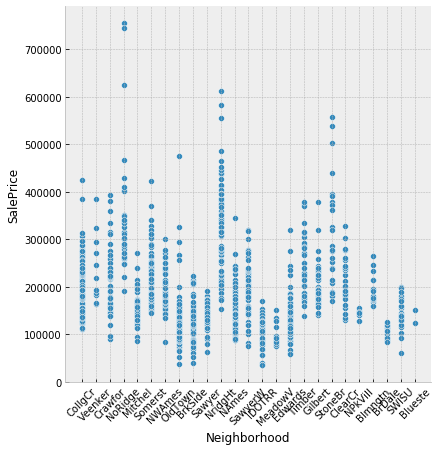

In [22]:
sns.pairplot(data=df_categ,
            x_vars='Neighborhood',
            y_vars=['SalePrice'],
            size = 6)
plt.xticks(rotation=45);

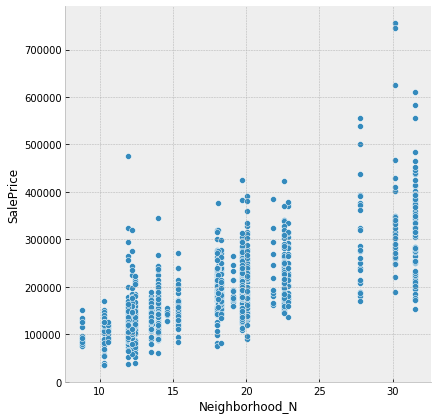

In [23]:
sns.pairplot(data=df_categN,
            x_vars='Neighborhood_N',
            y_vars=['SalePrice'],
            size = 6);

Spearman correlation to see the affect of category ranking by median *SalePrice*

In [24]:
print("Before category encoding:")
df_n = df_categ[df_categ['IsTrain'] == 1]
print(spearmanr(df_n['SalePrice'],df_n['Neighborhood']))

print("After category encoding:")
df_n = df_categN[df_categN['IsTrain'] == 1]
print(spearmanr(df_n['SalePrice'],df_n['Neighborhood_N']))
print("Pearson corr = "+ str(df_n.corr(method='pearson')['SalePrice']['Neighborhood_N']))

Before category encoding:
SpearmanrResult(correlation=0.16560873569214052, pvalue=1.9340263001151544e-10)
After category encoding:
SpearmanrResult(correlation=0.7554139806368404, pvalue=5.766733194698657e-270)
Pearson corr = 0.7335146673775423


Let's join the 2 datasets of encoded variables

In [25]:
df_categN = pd.merge(df_categN, df_categQ, left_index=True, right_index=True, sort=False)
#df_categN.columns

**Scatterplots** - *SalePrice* (col=0) across ranked categoric features

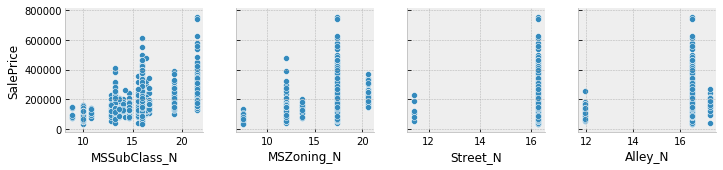

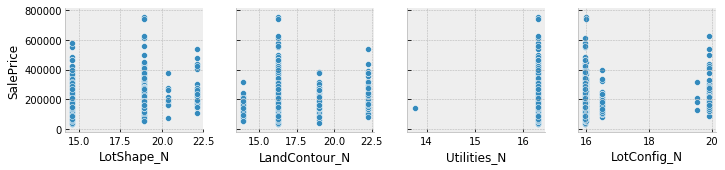

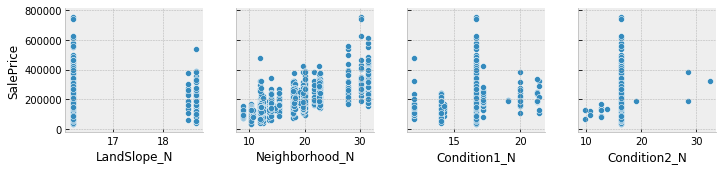

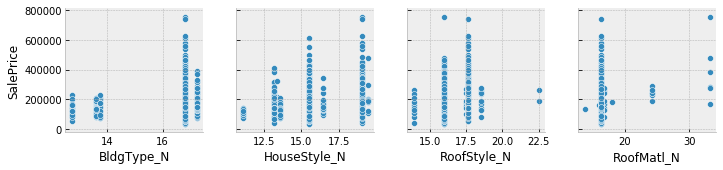

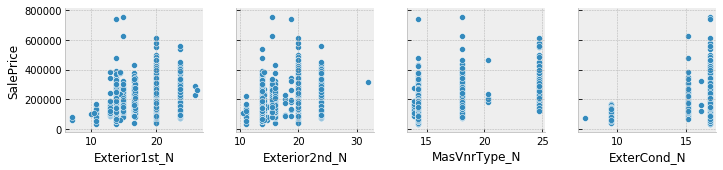

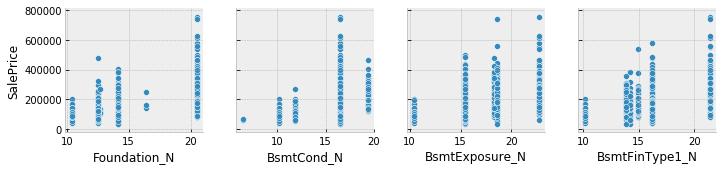

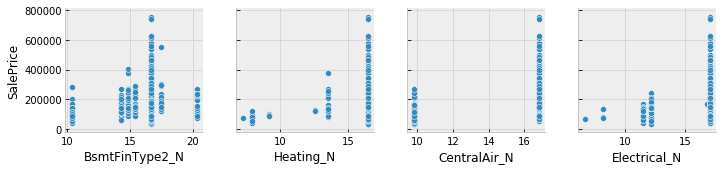

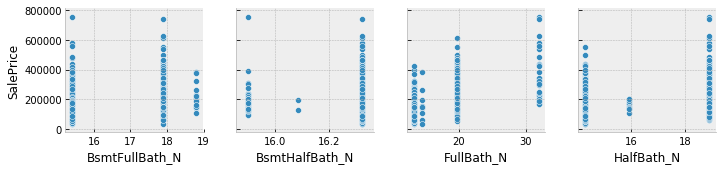

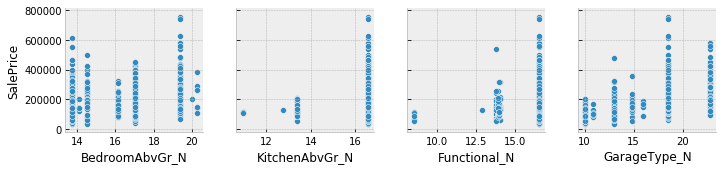

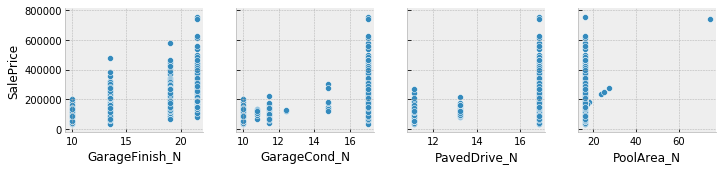

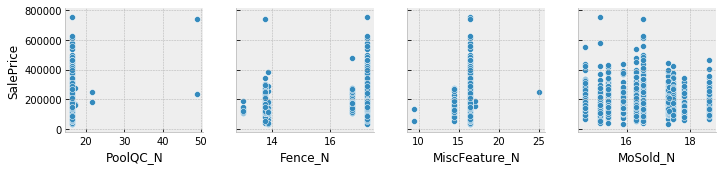

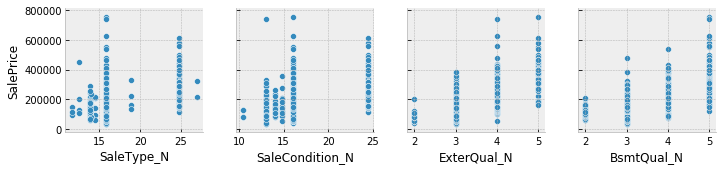

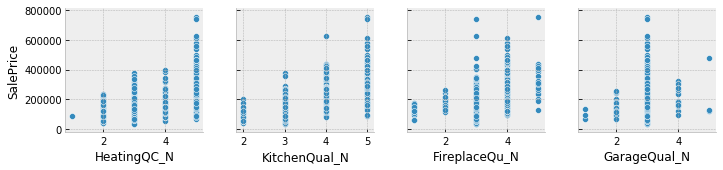

In [26]:
for i in range(2, len(df_categN.columns), 4):
    sns.pairplot(data=df_categN,
                x_vars=df_categN.columns[i:i+4],
                y_vars=['SalePrice'])

    
#### Will join the numeric and encoded categoric features

In [27]:
df = pd.merge(df_categN[df_categN.columns[2:]], df_num, left_index=True, right_index=True, sort=False)

### *Numeric Feature Analysis*

What's the shape of our target?    
Let's check out some key stats and histogram of *SalePrice*

In [28]:
df_num['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

In [29]:
#skewness and kurtosis
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


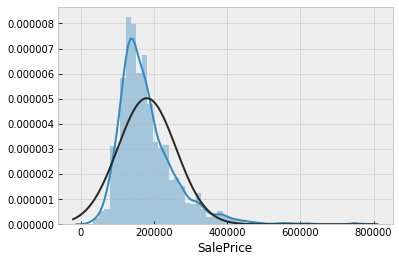

In [30]:
sns.distplot(df[df['SalePrice'].isnull() == False]['SalePrice'],fit=norm);

**The QQ-plot**
gives a nice picture of how close the sample quantiles are to the theoretical normal distribution quantiles

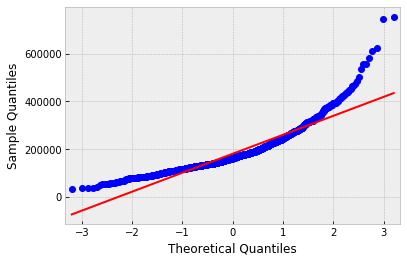

In [31]:
qqplot(df[df['SalePrice'].isnull() == False]['SalePrice'], line='s');

> Can see that the dependent variable will need a transformation to fulfill normality assumption, if linear regression is applied. Unlike the quantile regression, which is insensitive to monotone transformations of target variable. 

#### Histogram of other Numeric Features

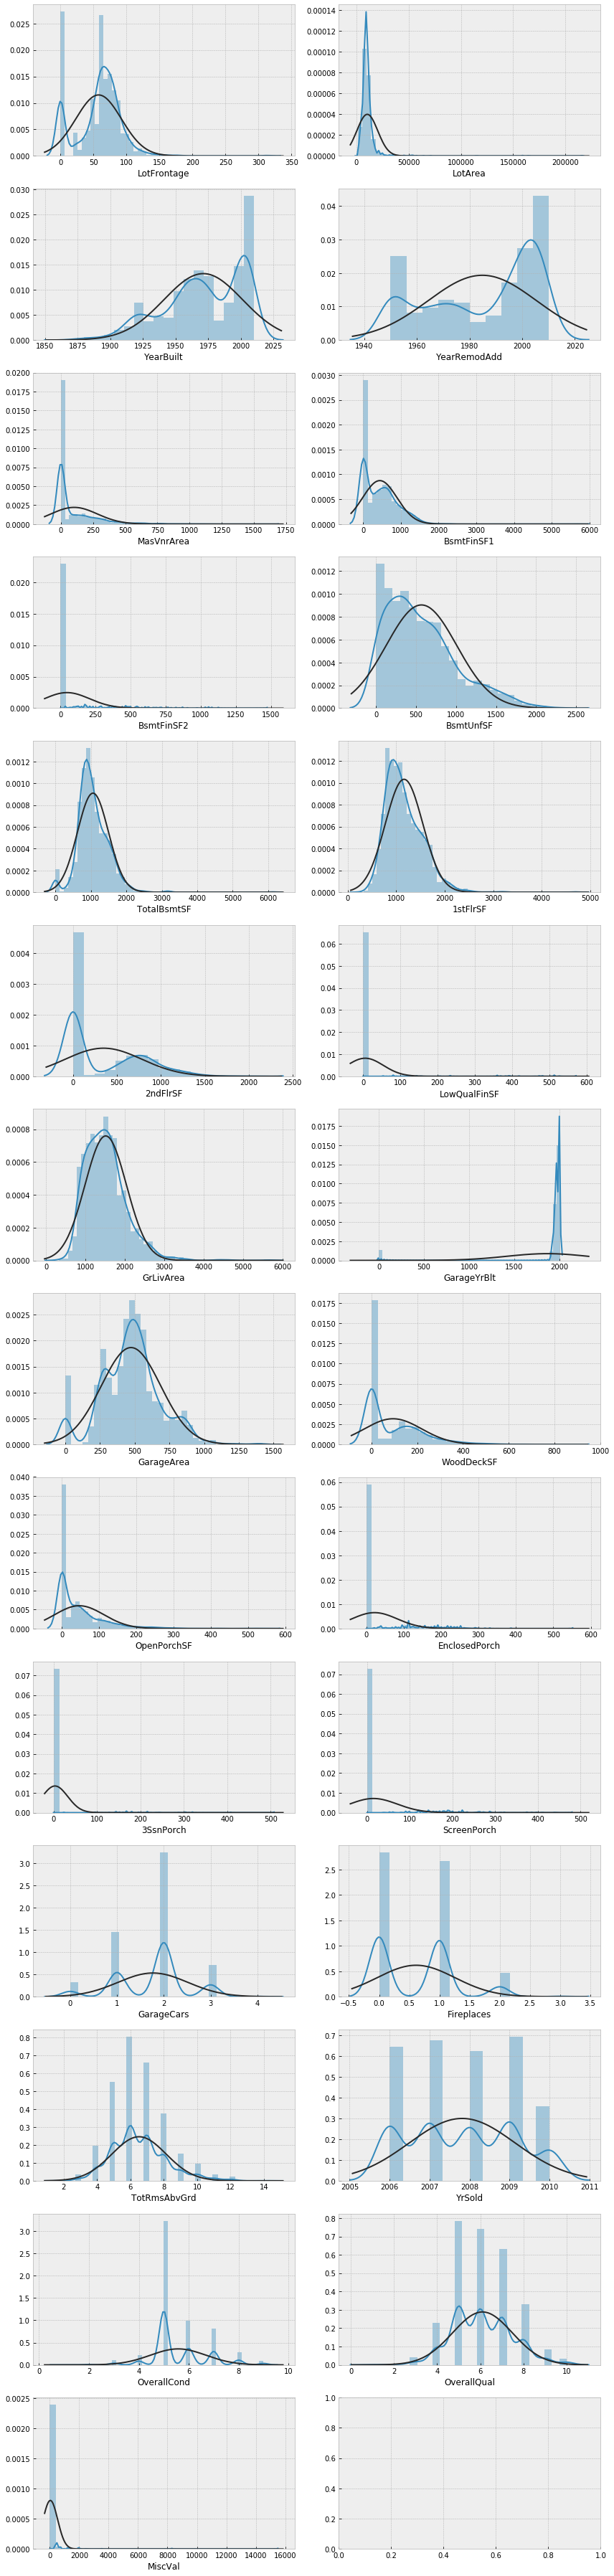

In [32]:
fig, axes = plt.subplots(round((len(df_num.columns)-2) / 2), 2, figsize=(12, 50))     # fig height = 70 -> in figsize(width,height)
for i, ax in enumerate(fig.axes):
    if i < (len(df_num.columns)-2):
        sns.distplot(df_num[df_num['IsTrain']==1][df_num.columns[i]], label="IsTrain = 1", fit=norm, ax=ax)

fig.tight_layout()

>There are features that have low coverage, keep in mind when evaluating its performance in the model outputs 

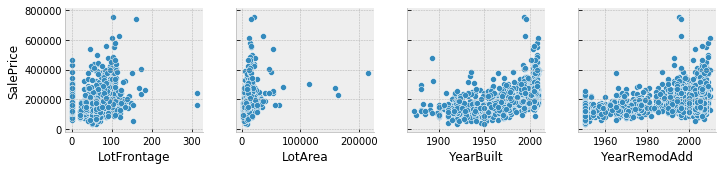

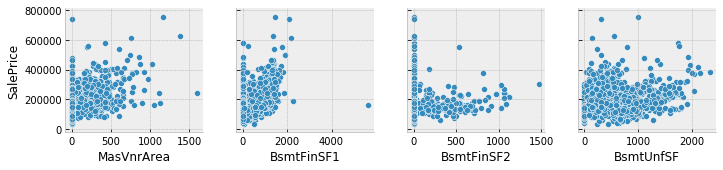

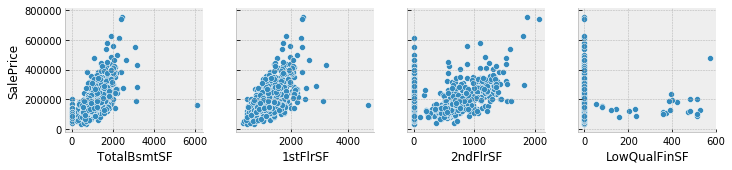

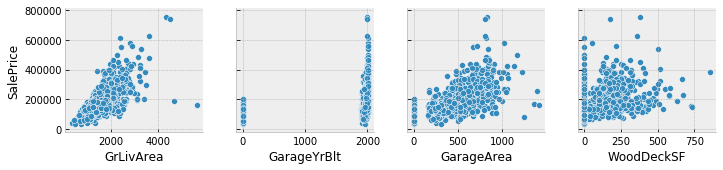

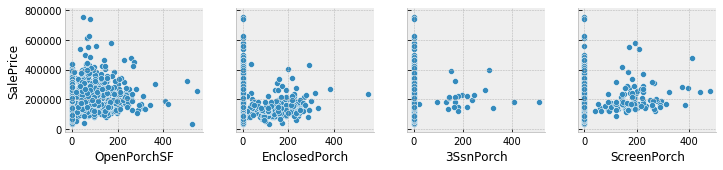

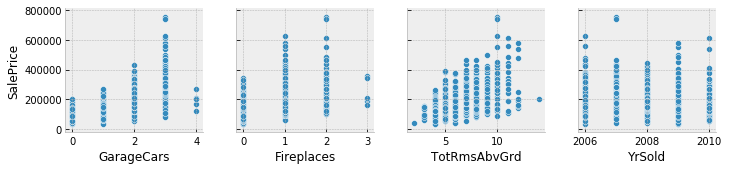

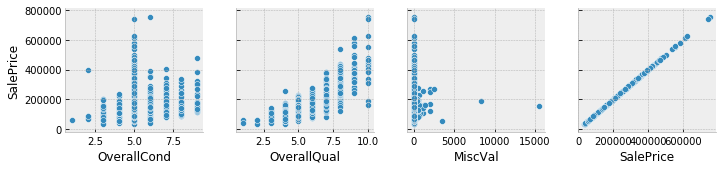

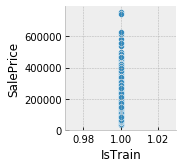

In [33]:
# Scatterplots SalePrice vs. numeric Vars
for i in range(0, len(df_num.columns), 4):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+4],
                y_vars=['SalePrice'])

### Correlation
Let's check which features have strongest linear relationship with *SalePrice*

In [34]:
df_corr = df.corr(method='pearson')['SalePrice'][:-2]   
golden_features_list = df_corr[abs(df_corr) > 0.3].sort_values(ascending=False)
print("There is {} correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))
#df[golden_features_list.index].head()

There is 35 correlated values with SalePrice:
OverallQual       0.791
Neighborhood_N    0.734
GrLivArea         0.709
ExterQual_N       0.683
KitchenQual_N     0.660
BsmtQual_N        0.650
GarageCars        0.640
GarageArea        0.623
TotalBsmtSF       0.614
1stFlrSF          0.606
FullBath_N        0.579
GarageFinish_N    0.552
TotRmsAbvGrd      0.534
YearBuilt         0.523
YearRemodAdd      0.507
Foundation_N      0.506
GarageType_N      0.499
MSSubClass_N      0.482
MasVnrArea        0.473
Fireplaces        0.467
BsmtFinType1_N    0.458
MasVnrType_N      0.432
HeatingQC_N       0.428
FireplaceQu_N     0.401
BsmtFinSF1        0.386
BsmtExposure_N    0.385
Exterior1st_N     0.385
Exterior2nd_N     0.379
SaleCondition_N   0.368
SaleType_N        0.366
MSZoning_N        0.325
WoodDeckSF        0.324
2ndFlrSF          0.319
OpenPorchSF       0.316
HalfBath_N        0.304
Name: SalePrice, dtype: float64


Create ***TotArea*** feature to cover all the area inside house, since all of these are highly corelated and sensibly important variables when predicting *SalePrice*

In [35]:
df.insert(loc=0, column='TotArea', value=(df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']) )

In [36]:
df.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea'], axis=1, inplace = True)

Let's check the strength (and direction) of linear relationship between key features

In [37]:
df_corr = df.corr(method='pearson')['SalePrice'][:-2]  
golden_features_list = df_corr[abs(df_corr) > 0.3].sort_values(ascending=False)
print("There is {} correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 32 correlated values with SalePrice:
OverallQual       0.791
TotArea           0.782
Neighborhood_N    0.734
ExterQual_N       0.683
KitchenQual_N     0.660
BsmtQual_N        0.650
GarageCars        0.640
GarageArea        0.623
FullBath_N        0.579
GarageFinish_N    0.552
TotRmsAbvGrd      0.534
YearBuilt         0.523
YearRemodAdd      0.507
Foundation_N      0.506
GarageType_N      0.499
MSSubClass_N      0.482
MasVnrArea        0.473
Fireplaces        0.467
BsmtFinType1_N    0.458
MasVnrType_N      0.432
HeatingQC_N       0.428
FireplaceQu_N     0.401
BsmtFinSF1        0.386
BsmtExposure_N    0.385
Exterior1st_N     0.385
Exterior2nd_N     0.379
SaleCondition_N   0.368
SaleType_N        0.366
MSZoning_N        0.325
WoodDeckSF        0.324
OpenPorchSF       0.316
HalfBath_N        0.304
Name: SalePrice, dtype: float64


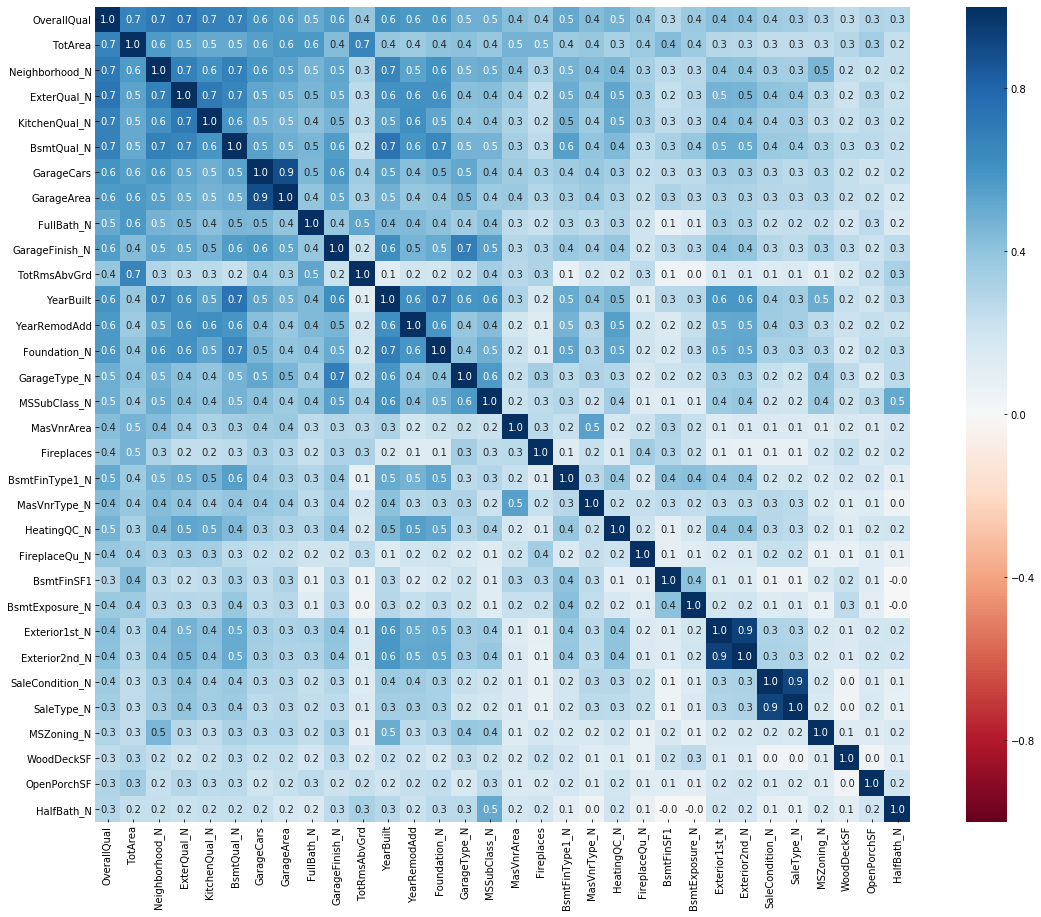

In [38]:
#correlation matrix heatmap
corrmat = df[golden_features_list.index].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, cmap="RdBu", vmin=-1, vmax=1, square=True, annot=True, fmt=".1f");

> There is strong correlation between some features. Will use PCA to gather the correlated features into components.

## 1. Quantile Regression

### 1.1. Prep: Initial train/test split for Visualised Model Evaluation

Will split the original training sample into train/test for model evaluation (70% training/ 30% testing)

In [39]:
# Separating out the features (and Training sample from Testing)
X = df.loc[:1459, golden_features_list.index].values

# Separating out the target
y = df.iloc[:1460,-2].values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### 1.2. Standardize Data

Feature standardization is required for Principal component analysis (PCA)

In [40]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_Y = StandardScaler()
y_trainS = sc_Y.fit_transform(y_train.reshape(-1,1))
y_testS = sc_Y.transform(y_test.reshape(-1,1))

In [41]:
print("mean = " + str(np.mean(X_train[:,4])))
print("std = " + str(np.std(X_train[:,4])))

mean = -1.772880602923929e-16
std = 0.999999999999995


### 1.3. PCA for feature reduction and independence

Let's put the potential predictors through PCA to create few independent components that could go into the model instead

In [42]:
pca = PCA(n_components = 5)
principalComponents = pca.fit_transform(X_train)
principalComponentsTest = pca.transform(X_test)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PrincComp_1', 'PrincComp_2','PrincComp_3','PrincComp_4','PrincComp_5'])
principalDftest = pd.DataFrame(data = principalComponentsTest
             , columns = ['PrincComp_1', 'PrincComp_2','PrincComp_3','PrincComp_4','PrincComp_5'])

Percentage of variace explained by the components together and seperately

In [43]:
print('Variance explained by all components: ' + str(pca.explained_variance_ratio_.sum()))
pca.explained_variance_ratio_

Variance explained by all components: 0.5825863840720821


array([0.36579365, 0.06948919, 0.05540083, 0.05160044, 0.04030228])

Let's see which variables mostly contribute to which component

In [44]:
compareDf = pd.concat((principalDf, pd.DataFrame(X_train, columns = golden_features_list.index)), axis=1)

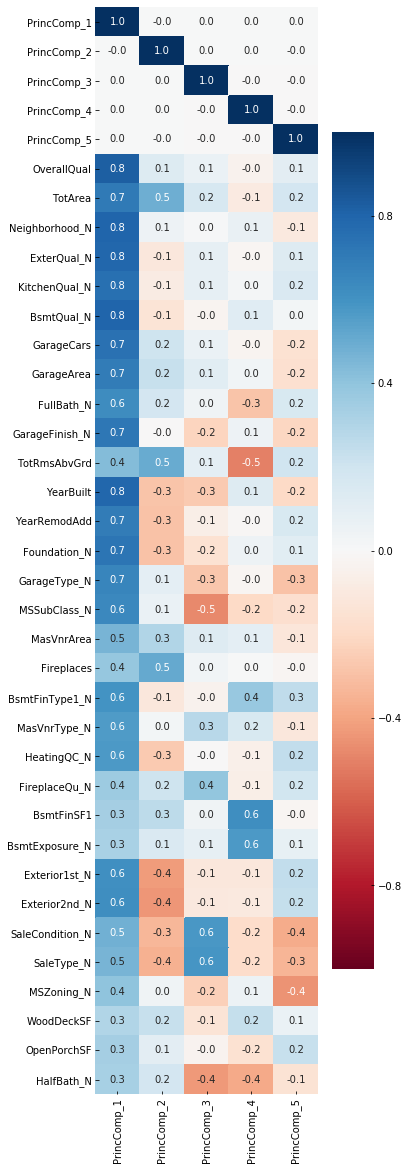

In [45]:
corrmat = compareDf.corr()['PrincComp_1':'PrincComp_5'].transpose()
f, ax = plt.subplots(figsize=(5, 20))
sns.heatmap(corrmat, cmap="RdBu", vmin=-1, vmax=1, square=False, annot=True, fmt=".1f");

We assign to create as many components as would explain 95% of the variance

### 1.4. Quantile Regression - model fitting

The Least Absolute Deviation model is a special case of quantile regression where q=0.5 (median)

In [46]:
principalDf['SalePrice'] = y_trainS

In [47]:
mod = sm.quantreg('SalePrice ~ PrincComp_1 + PrincComp_2 + PrincComp_3 + PrincComp_4 + PrincComp_5', principalDf)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              SalePrice   Pseudo R-squared:               0.6092
Model:                       QuantReg   Bandwidth:                      0.1372
Method:                 Least Squares   Sparsity:                       0.6896
Date:                Wed, 12 Jun 2019   No. Observations:                 1022
Time:                        14:17:09   Df Residuals:                     1016
                                        Df Model:                            5
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0308      0.011     -2.855      0.004      -0.052      -0.010
PrincComp_1     0.2251      0.003     71.413      0.000       0.219       0.231
PrincComp_2     0.1599      0.007     22.109      0.000       0.146       0.174
PrincComp_3     0.0863      0.008     10.651   

### 1.5. Model Evaluation

Inverse the transformation (since we applied the transformation prior to analysis)

In [48]:
pred = res.predict(principalDftest) # make the predictions by the model
y_pred = sc_Y.inverse_transform(pred)

See if the errors increase when SalePrice increases (e.g. maybe the model is performing better on lower-value houses rather than the expensive)

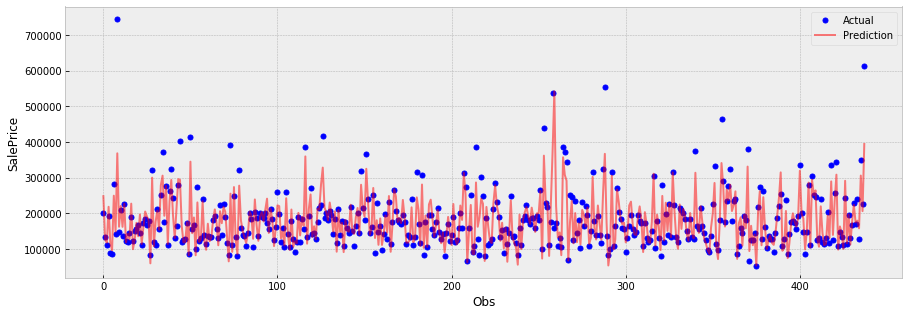

In [49]:
# Plot the y_test and the prediction (y_pred)
fig = plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(y_test),1), y_test, 'b.', markersize=10, label='Actual')
plt.plot(np.arange(0,len(y_test),1), y_pred, 'r-', label='Prediction', alpha =0.5)
plt.xlabel('Obs')
plt.ylabel('SalePrice')
#plt.ylim(-10, 20)
plt.legend(loc='upper right');

Observations sorted by y_test values, i.e. higher index => higher SalePrice value


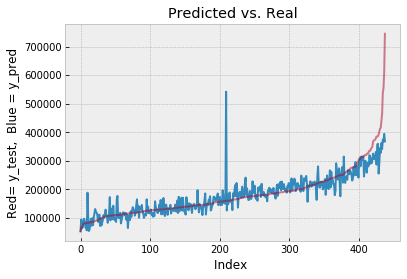

In [50]:
DFyy = pd.DataFrame({'y_test':y_test,'y_pred': y_pred})
DFyy.sort_values(by=['y_test'],inplace=True)
plt.plot(np.arange(0,len(DFyy),1), DFyy['y_pred'])
plt.plot(np.arange(0,len(DFyy),1), DFyy['y_test'], alpha=0.5)
#plt.ylim(0,500000)
plt.ylabel('Red= y_test,  Blue = y_pred')
plt.xlabel('Index ')
plt.title('Predicted vs. Real');
print('Observations sorted by y_test values, i.e. higher index => higher SalePrice value');

Observations sorted by y_test values, i.e. higher index => higher SalePrice value


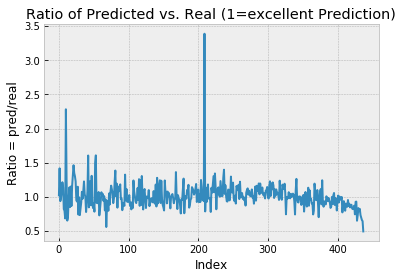

In [51]:
plt.plot(np.arange(0,len(DFyy),1), DFyy['y_pred']/DFyy['y_test'])
plt.ylabel('Ratio = pred/real')
plt.xlabel('Index')
plt.title('Ratio of Predicted vs. Real (1=excellent Prediction)');
print('Observations sorted by y_test values, i.e. higher index => higher SalePrice value');

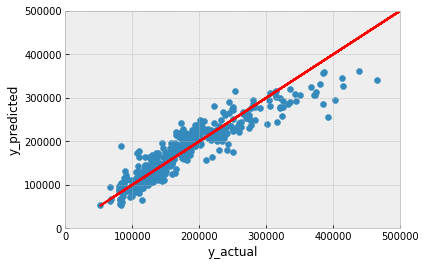

In [52]:
plt.scatter(y_test, y_pred)
plt.ylim(-1, 500000)
plt.xlim(-1, 500000)
plt.plot(y_test, y_test, "r")
plt.xlabel('y_actual')
plt.ylabel('y_predicted');

See how the relative residuals are distributed across testing sample

Observations sorted by y_test values, i.e. higher index => higher SalePrice value


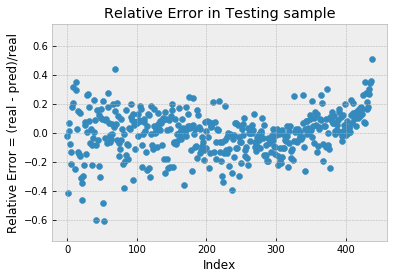

In [53]:
plt.scatter(np.arange(0,len(DFyy),1), (DFyy['y_test'] - DFyy['y_pred'])/DFyy['y_test'] )
plt.ylim(-0.75,0.75)
plt.ylabel('Relative Error = (real - pred)/real')
plt.xlabel('Index')
plt.title('Relative Error in Testing sample');
print('Observations sorted by y_test values, i.e. higher index => higher SalePrice value');

Define RMSLE metrics for model evaluation and comparison

In [54]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative
            print('Warning:1 negative value skipped')
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [55]:
print('Prediction accuracy on Testing Sample:')
print('RMSLE       = %f' % (rmsle(y_test, y_pred)))
print('r-squared   = %f' % (r2_score(y_test, y_pred)))

Prediction accuracy on Testing Sample:
RMSLE       = 0.168156
r-squared   = 0.756569


In [56]:
pred_train = res.predict(principalDf)
y_pred_train = sc_Y.inverse_transform(pred_train)

In [57]:
print('Model accuracy on Training Sample:')
print('RMSLE       = %f' % (rmsle(y_train, y_pred_train)))
print('r-squared   = %f' % (r2_score(y_train, y_pred_train)))

Model accuracy on Training Sample:
RMSLE       = 0.168971
r-squared   = 0.812707


### 1.6. Model Stability check - using kFolds

In [58]:
skf = KFold(n_splits=3, shuffle=True, random_state=123)

In [59]:
i = 1
Intercept_CV   = list()
PrincComp_1_CV = list()
PrincComp_2_CV = list()
PrincComp_3_CV = list()
PrincComp_4_CV = list()
PrincComp_5_CV = list()

for train_index, test_index in skf.split(X,y):
    #------ Standardize -------
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X[train_index])
    X_test = sc_X.transform(X[test_index])
    sc_Y = StandardScaler()
    y_trainS = sc_Y.fit_transform(y[train_index].reshape(-1,1))
    y_test = y[test_index]
    #----- PCA ----------------
    pca = PCA(n_components = 5)
    principalComponents = pca.fit_transform(X_train)
    principalComponentsTest = pca.transform(X_test)
    
    #---- Applying the Standard scaler so the parameters are easier to compare
    ScPCA = StandardScaler()
    principalComponents = ScPCA.fit_transform(principalComponents)
    principalComponentsTest = ScPCA.transform(principalComponentsTest)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PrincComp_1', 'PrincComp_2','PrincComp_3','PrincComp_4','PrincComp_5'])
    principalDftest = pd.DataFrame(data = principalComponentsTest
             , columns = ['PrincComp_1', 'PrincComp_2','PrincComp_3','PrincComp_4','PrincComp_5'])
    principalDf['SalePrice'] = y_trainS
    
    #principalDf = StandardScaler().fit_transform(principalDf)
    
    #----- QUANTILE REGRESSION ----------
    mod = sm.quantreg('SalePrice ~ PrincComp_1 + PrincComp_2 + PrincComp_3 + PrincComp_4 + PrincComp_5', principalDf)
    res = mod.fit(q=.5)
    pred = res.predict(principalDftest) # make the predictions by the model
    y_pred = sc_Y.inverse_transform(pred)
    print('Split No.: ' + str(i))
    print('RMSLE       = %f' % (rmsle(y_test, y_pred)))
    print('r-squared   = %f' % (r2_score(y_test, y_pred)))
    
    Intercept_CV.append(res.params['Intercept'])
    PrincComp_1_CV.append(res.params['PrincComp_1'])
    PrincComp_2_CV.append(res.params['PrincComp_2'])
    PrincComp_3_CV.append(res.params['PrincComp_3'])
    PrincComp_4_CV.append(res.params['PrincComp_4'])
    PrincComp_5_CV.append(res.params['PrincComp_5'])
    i=i+1

#--- Model Stability Check: Mean and standard deviation of each regression parameter
print('Intercept mean = ' + str(np.mean(Intercept_CV)) + ' std = ' + str(np.std(Intercept_CV)))
print('PrincComp_1 mean = ' + str(np.mean(PrincComp_1_CV)) + ' std = ' + str(np.std(PrincComp_1_CV)))
print('PrincComp_2 mean = ' + str(np.mean(PrincComp_2_CV)) + ' std = ' + str(np.std(PrincComp_2_CV)))
print('PrincComp_3 mean = ' + str(np.mean(PrincComp_3_CV)) + ' std = ' + str(np.std(PrincComp_3_CV)))
print('PrincComp_4 mean = ' + str(np.mean(PrincComp_4_CV)) + ' std = ' + str(np.std(PrincComp_4_CV)))
print('PrincComp_5 mean = ' + str(np.mean(PrincComp_5_CV)) + ' std = ' + str(np.std(PrincComp_5_CV)))

Split No.: 1
RMSLE       = 0.162424
r-squared   = 0.796493
Split No.: 2
RMSLE       = 0.213104
r-squared   = 0.800968
Split No.: 3
RMSLE       = 0.177211
r-squared   = 0.772101
Intercept mean = -0.02954439009794871 std = 0.007316926599148454
PrincComp_1 mean = 0.7698104811755192 std = 0.006137537913596584
PrincComp_2 mean = 0.22044837527680006 std = 0.015835906042242748
PrincComp_3 mean = 0.09416726265137636 std = 0.013867065977654329
PrincComp_4 mean = 0.022054713521284356 std = 0.01502285660330104
PrincComp_5 mean = 0.05394955847947066 std = 0.01065842677171469


## 2. Gradient Boosted Regression
Compare the outputs of quantile regression accuracy to Gradient boosted regression outputs

In [60]:
# Separating out the features (and Training sample from Testing)
X = df.iloc[:1460, :-2].values

# Separating out the target
y = df.iloc[:1460,-2].values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [61]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [62]:
GBRmedian = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=250, max_depth=5,
                                learning_rate=.1, min_samples_leaf=10,
                                min_samples_split=20)
GBRmedian.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=20,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Let's fit the Gradient boosted regression tree based on quantile =0.5 (LAD) loss function (i.e. estimating the median value)

In [63]:
# Make the prediction on the Testing sample
y_pred = GBRmedian.predict(X_test)
y_pred_train = GBRmedian.predict(X_train)

In [64]:
print('Model Accuracy on Training sample:')
print('RMSLE       = %f' % (rmsle(y_train, y_pred_train)))
print('r-squared   = %f' % (r2_score(y_train, y_pred_train)))

Model Accuracy on Training sample:
RMSLE       = 0.080187
r-squared   = 0.950597


In [65]:
print('Accuracy of prediction on Testing sample:')
print('RMSLE       = %f' % (rmsle(y_test, y_pred)))
print('r-squared   = %f' % (r2_score(y_test, y_pred)))

Accuracy of prediction on Testing sample:
RMSLE       = 0.124305
r-squared   = 0.878204


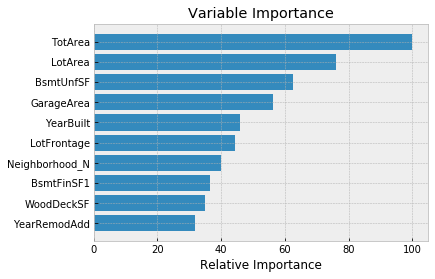

In [66]:
# Plot feature importance
feature_importance = GBRmedian.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
# Let's plot to top10 most important variables
sorted_idx = sorted_idx[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

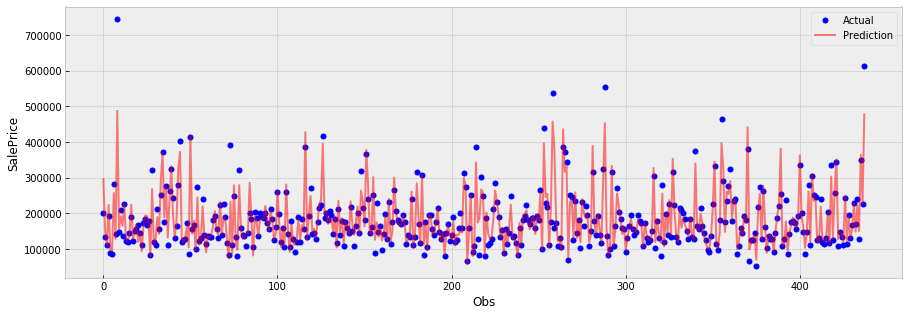

In [67]:
# Plot the y_test and the prediction (y_pred)
fig = plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(y_test),1), y_test, 'b.', markersize=10, label='Actual')
plt.plot(np.arange(0,len(y_test),1), y_pred, 'r-', label='Prediction', alpha = 0.5)
plt.xlabel('Obs')
plt.ylabel('SalePrice')
#plt.ylim(-10, 20)
plt.legend(loc='upper right');

Observations sorted by y_test values, i.e. higher index => higher SalePrice value


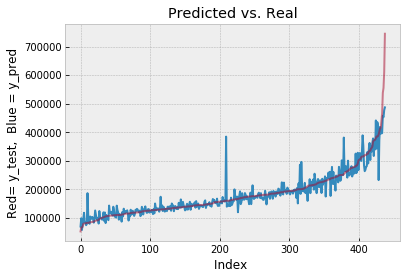

In [68]:
DFyy = pd.DataFrame({'y_test':y_test,'y_pred': y_pred})
DFyy.sort_values(by=['y_test'],inplace=True)
plt.plot(np.arange(0,len(DFyy),1), DFyy['y_pred'])
plt.plot(np.arange(0,len(DFyy),1), DFyy['y_test'], alpha=0.5)
#plt.ylim(0,500000)
plt.ylabel('Red= y_test,  Blue = y_pred')
plt.xlabel('Index ')
plt.title('Predicted vs. Real');
print('Observations sorted by y_test values, i.e. higher index => higher SalePrice value');

Observations sorted by y_test values, i.e. higher index => higher SalePrice value


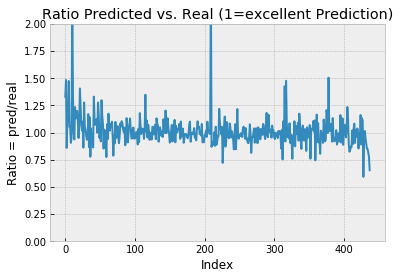

In [69]:
plt.plot(np.arange(0,len(DFyy),1), DFyy['y_pred']/DFyy['y_test'])
plt.ylabel('Ratio = pred/real')
plt.xlabel('Index')
plt.ylim(0,2)
plt.title('Ratio Predicted vs. Real (1=excellent Prediction)');
print('Observations sorted by y_test values, i.e. higher index => higher SalePrice value');

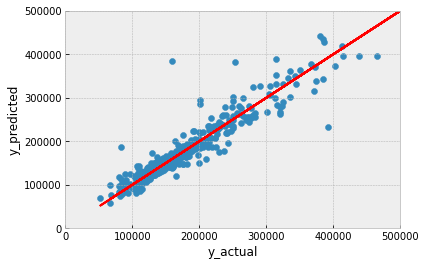

In [70]:
plt.scatter(y_test, y_pred)
plt.ylim(-1, 500000)
plt.xlim(-1, 500000)
plt.plot(y_test, y_test, "r")
plt.xlabel('y_actual')
plt.ylabel('y_predicted');

See how the residuals are distributed across testing sample

Observations sorted by y_test values, i.e. higher index => higher SalePrice value


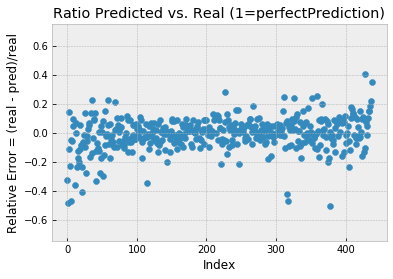

In [71]:
plt.scatter(np.arange(0,len(DFyy),1), (DFyy['y_test'] - DFyy['y_pred'])/DFyy['y_test'] )
plt.ylim(-0.75,0.75)
plt.ylabel('Relative Error = (real - pred)/real')
plt.xlabel('Index')
plt.title('Ratio Predicted vs. Real (1=perfectPrediction)');
print('Observations sorted by y_test values, i.e. higher index => higher SalePrice value');

> When we compare prediction error in the tails, gradient boosting seems to give better accuracy for lowest and highest value houses.

### GBR Model Stability

Accuracy of prediction on Testing sample:
RMSLE       = 0.127562
r-squared   = 0.869214


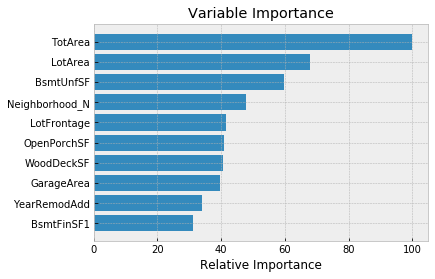

Accuracy of prediction on Testing sample:
RMSLE       = 0.136955
r-squared   = 0.868257


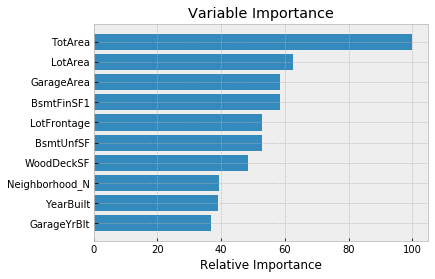

Accuracy of prediction on Testing sample:
RMSLE       = 0.132141
r-squared   = 0.878734


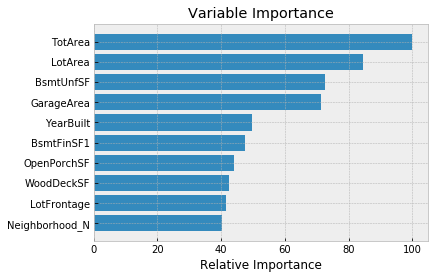

In [72]:
skf = KFold(n_splits=3, shuffle=True, random_state=123)

for train_index, test_index in skf.split(X,y):
    #------ Standardize -------
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X[train_index])
    X_test = sc_X.transform(X[test_index])
    y_train = y[train_index]
    y_test = y[test_index]
    
    #----- Gradient Boosted Regression ----------
    GBRmedian = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                    n_estimators=250, max_depth=5,
                                    learning_rate=.1, min_samples_leaf=10,
                                    min_samples_split=20)
    GBRmedian.fit(X_train, y_train)
    # Make the prediction on the Testing sample
    y_pred = GBRmedian.predict(X_test)
    y_pred_train = GBRmedian.predict(X_train)

    print('Accuracy of prediction on Testing sample:')
    print('RMSLE       = %f' % (rmsle(y_test, y_pred)))
    print('r-squared   = %f' % (r2_score(y_test, y_pred)))
    
    #---------------------------
    # Plot feature importance
    feature_importance = GBRmedian.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    # Let's plot to top10 most important variables
    sorted_idx = sorted_idx[-10:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show();


### Conclusion
Gradient Boosted Regression gives better accuracy compared to quantile regression, though the difference is not that big between RMSLEs (0.13 vs. 0.17). In the evaluation charts can see and compare how well the models predict across the testing sample.
If we compare model stability outputs - predictor variable importance order is changing in every fold, where in quantile regression equation slope coefficients (of principal components) doesn't change much, i.e. the importance of predictors (and contribution to the model) is stable. This is one of the reasons why some business sectors still choose to use traditional methods over advanced machine learning.

### References

- Great tips on Exploratory Data Analysis by [Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) and [Tuatini Godard](https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python), Categorical Data Analysis by [Samarth Agrawal](https://www.kaggle.com/nextbigwhat/eda-for-categorical-variables-a-beginner-s-way)
- Gradient Boosting - nice intuitive explanation on how gradient boosting works [here](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)   
- Principal Component Analysis https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60  
- Quantile Regression http://www.statsmodels.org/dev/generated/statsmodels.regression.quantile_regression.QuantReg.html  
- More about quantile regression and Gradient boosting quantiles predictions [here](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3)